In [5]:
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep

## `Sectiion 1`
Generate functions
 - Open and read image function
 - Display image function
 - Save image function

In [6]:
# Function to open and read images
def op_read(image):
    im = rio.open(image).read(masked=True)[0].astype('f4')
    return im
    
# Function to display VI image
def display(vi, name):
    fig, ax = plt.subplots(figsize=(7,7))
    ep.plot_bands(vi, ax=ax, cmap='RdYlGn', 
                  title=name+' 18Jan23')
    plt.show()
 
# Function to save VI image 
with rio.open("C:/Maize_Chainat_C/2.18Jan23/18Jan_Green.tif") as src:
    data = src.read(1).astype('f4')

output_path = "C:/Maize_Chainat_C/2.18Jan23/VI_Images"
def save(vi, name):
    # Set the spatial metadata (same as input image)
    profile = src.meta
    profile.update(driver='GTiff', dtype=rio.float32, count=1)
    #profile.update(driver='GTiff', dtype=rio.uint8, count=1)

    # Set the VI image name
    out_image = os.path.join(output_path, name + '_subtrac_soil.tif')
    # Save the file
    with rio.open(out_image, 'w', **profile) as dst:
        dst.write_band(1, vi.astype(rio.float32))

## `Section 2`
Import images

In [7]:
# Import imags using the created function
red = op_read("C:/Maize_Chainat_C/2.18Jan23/18Jan_Red.tif") # r668
green = op_read("C:/Maize_Chainat_C/2.18Jan23/18Jan_Green.tif") # g560
blue = op_read("C:/Maize_Chainat_C/2.18Jan23/18Jan__Blue.tif") # b475
nir = op_read("C:/Maize_Chainat_C/2.18Jan23/18Jan_NIR.tif") # n842
rededge = op_read("C:/Maize_Chainat_C/2.18Jan23/18Jan_RedEdge.tif") # re717

## `Section 3`
Find the soil subtraction threshold from SAVI
 - Create SAVI image
 - Find the threshold and crate a masking image

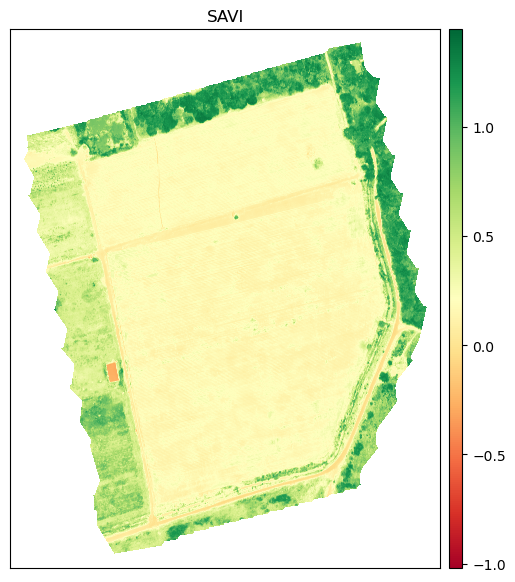

In [8]:
# Ignore the default of numpy about deviding with zero
np.seterr(divide='ignore', invalid='ignore')
# SAVI mask
savi = 1.5 * (nir-red) / (nir+red+0.5)
# Save SAVI in the output directory to check the thershold in QGIS&ImageJ(Otsu)
save(savi, 'SAVI')
# Display SAVI image
fig, ax = plt.subplots(figsize=(7,7))
ep.plot_bands(savi, title='SAVI', cmap='RdYlGn', ax=ax)
plt.show()

In [9]:
# Set threshold from SAVI image
thr_soil = 0.45 # *Change the number
# Create soil masking from OSAVI
savi[savi < thr_soil] = 0.0 
savi[savi > 0] = 1.0 # 
mask = savi
save(mask, 'mask')

## `Section 4`
Calculate VI images
 - NDVI
 - GNDVI
 - NDRE
 - RDVI
 - CIgreen
 - CIrededge
 - RGBVI
 - OSAVI
 - EVI2
 - MCARI2
 - MTVI2
 - NDWI

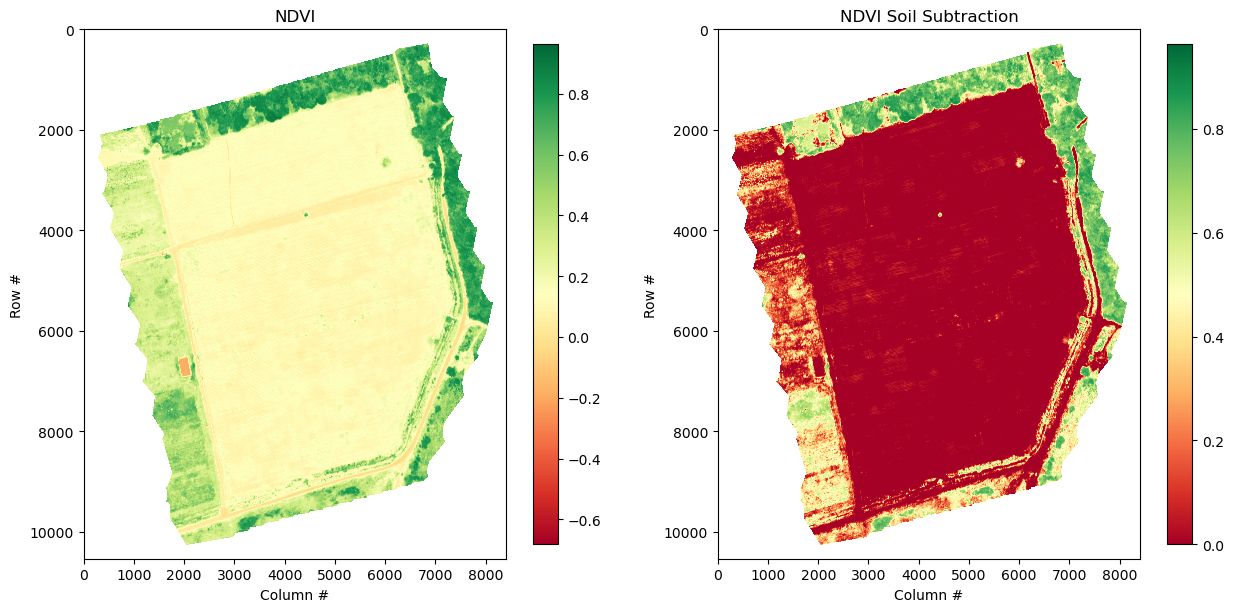

In [10]:
# Calculate VI using numpy array
# NDVI
ndvi = (nir-red) / (nir+red)
ndvi_s = ndvi * mask
save(ndvi_s, 'NDVI')

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(15, 10))
plt.sca(ax1)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(shrink=0.65)
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(ax2)
plt.imshow(ndvi_s, cmap='RdYlGn')
plt.colorbar(shrink=0.65)
plt.title('NDVI Soil Subtraction')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.show()

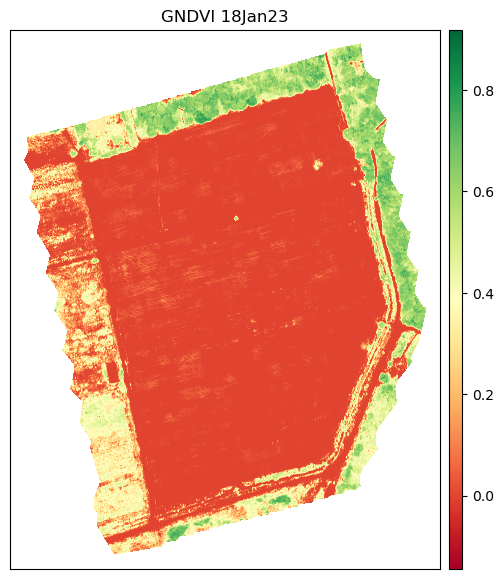

In [11]:
# GNDVI
gndvi = (nir-green) / (nir+green)
gndvi_s = gndvi * mask
display(gndvi_s, 'GNDVI')
save(gndvi_s, 'GNDVI')

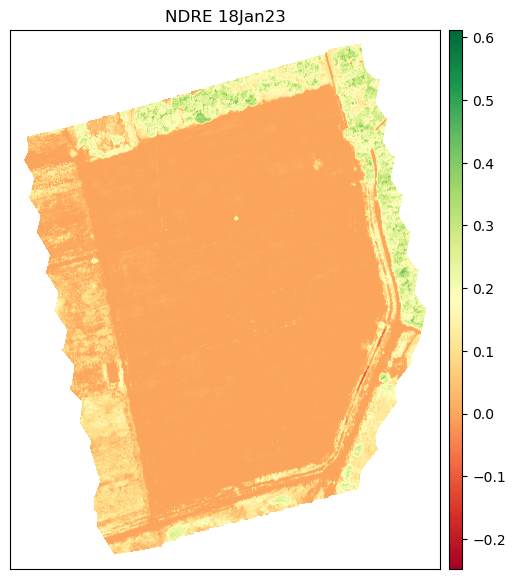

In [12]:
# NDRE
ndre = (nir-rededge) / (nir+rededge)
ndre_s = ndre * mask
display(ndre_s, 'NDRE')
save(ndre_s, 'NDRE')

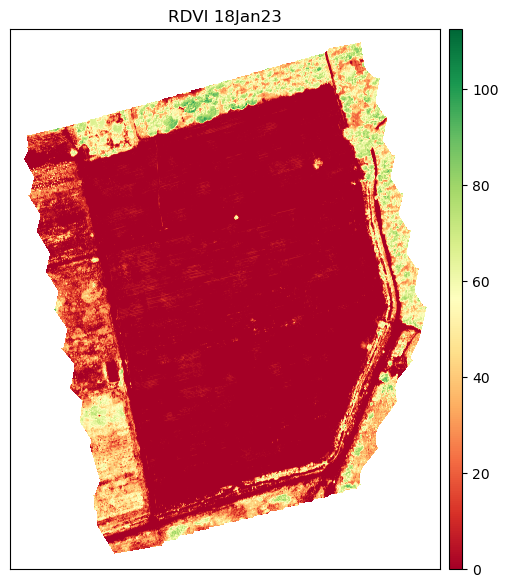

In [13]:
# RDVI
rdvi = (nir-red) / (np.sqrt(nir+red))
rdvi_s = rdvi * mask
display(rdvi_s, 'RDVI')
save(rdvi_s, 'RDVI')

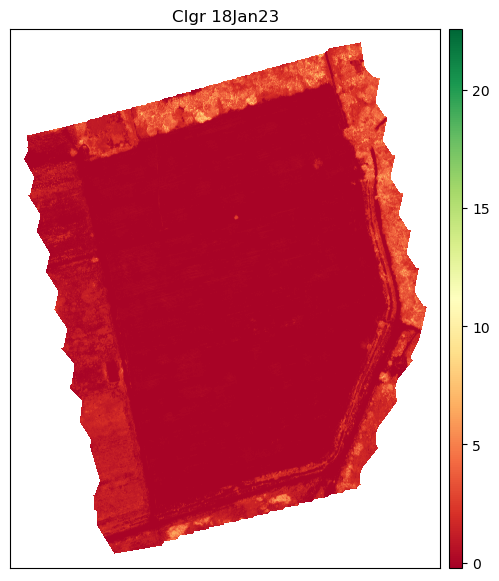

In [14]:
# CIgreen
cigreen = (nir/green) - 1
cigreen_s = cigreen * mask
display(cigreen_s, 'CIgr')
save(cigreen_s, 'CIgr')

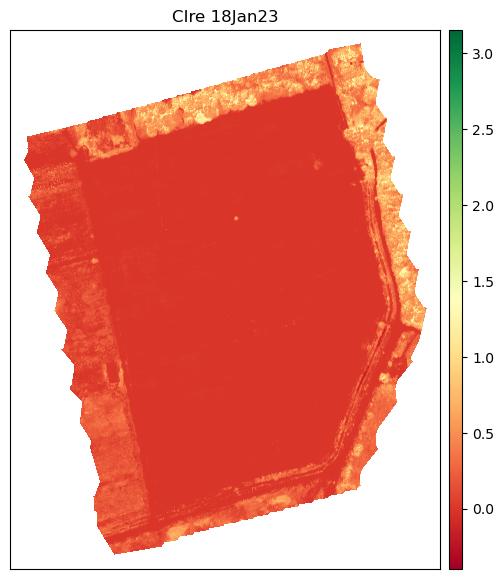

In [15]:
# CIrededge
cirededge = (nir/rededge) - 1
cirededge_s = cirededge * mask
display(cirededge_s, 'CIre')
save(cirededge_s, 'CIre')

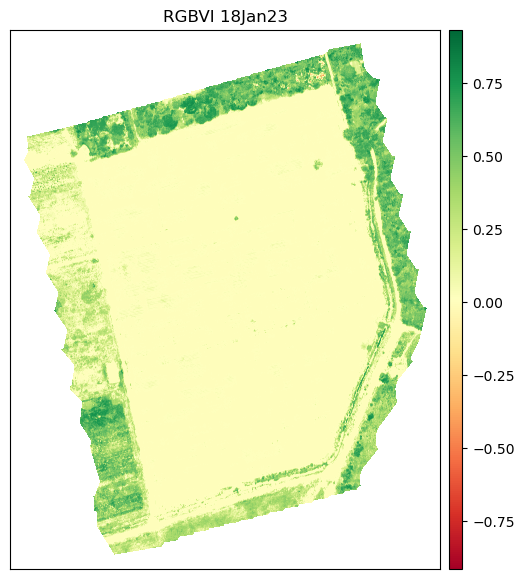

In [16]:
# RGBVI
rgbvi = ((green*green) - (blue*red)) / ((green*green) + (blue*red))
rgbvi_s = rgbvi * mask
display(rgbvi_s, 'RGBVI')
save(rgbvi_s, 'RGBVI')

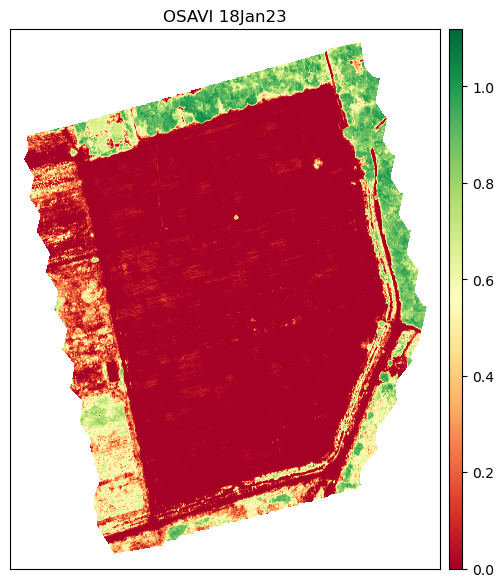

In [17]:
# OSAVI
osavi = 1.16 * (nir-red) / (nir+red+0.16)
osavi_s = osavi * mask
display(osavi_s, 'OSAVI')
save(osavi_s, 'OSAVI')

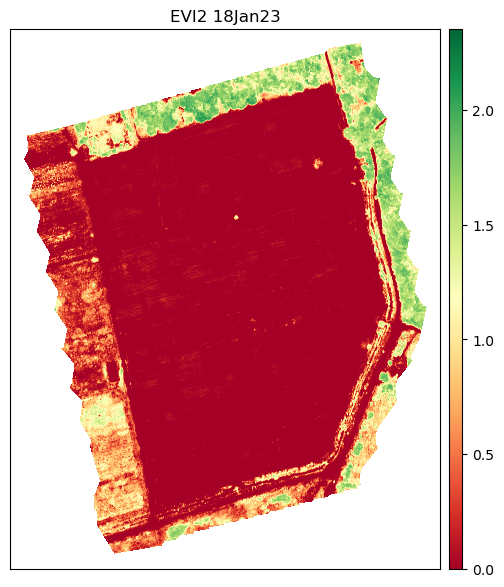

In [18]:
# EVI2
evi2 = 2.5*((nir-red)/(nir+(2.4*red)+1))
evi2_s = evi2*mask
display(evi2_s, 'EVI2')
save(evi2_s, 'EVI2')

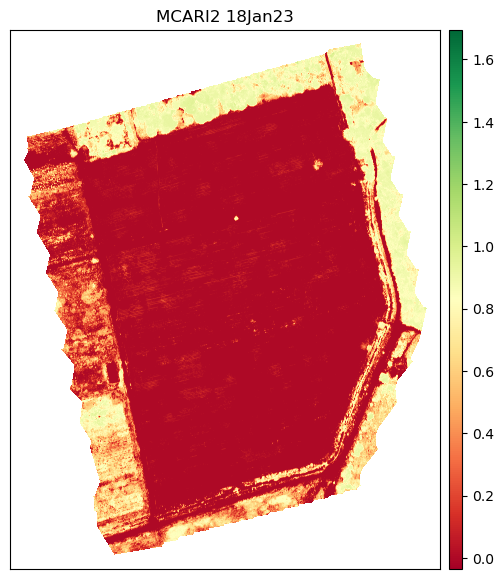

In [19]:
# MCARI2
c = 1.5*(2.5*(nir-red)-1.3*(nir-green))
d = np.sqrt(((2*nir+1)**2)-(6*nir-5*(np.sqrt(red)))-0.5)
mcari2 = c/d
mcari2_s = mcari2*mask
display(mcari2_s, 'MCARI2')
save(mcari2_s, 'MCARI2')

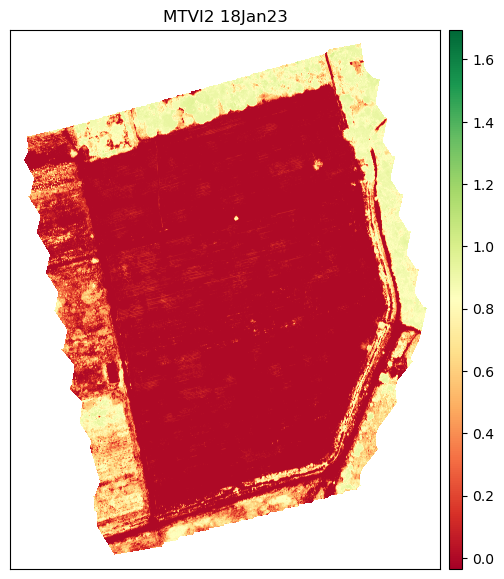

In [20]:
# MTVI2
a = 1.5*(1.2*(nir-green)-2.5*(red-green))
b = np.sqrt(((2*nir+1)**2)-(6*nir-5*(np.sqrt(red)))-0.5)
mtvi2 = a/b
mtvi2_s = mtvi2*mask
display(mtvi2_s, 'MTVI2')
save(mtvi2_s, 'MTVI2')

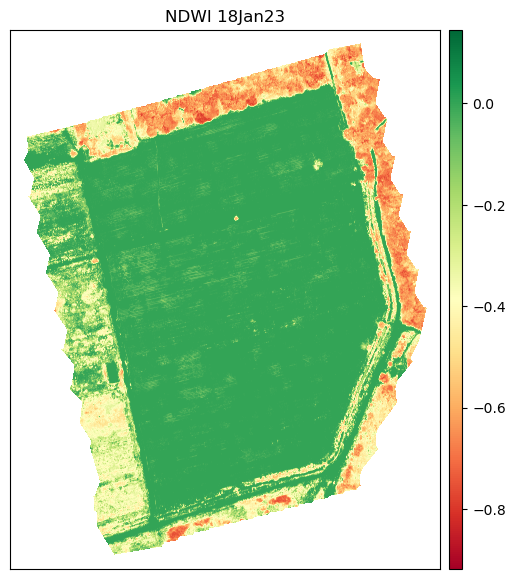

In [21]:
# NDWI
ndwi= (green - nir) / (green + nir)
ndwi_s = ndwi * mask
display(ndwi_s, 'NDWI')
save(ndwi_s, 'NDWI')

## `Section 5`
Extrac VI values

In [1]:
import geopandas as gpd
from rasterstats import zonal_stats
from pathlib import Path
import numpy as np
import os

# Import plot segmetation shapefile
plot = gpd.read_file("C:/Maize_Chainat_C/ROI_45point_4326_1to45.shp")

#Plot ShapeFile
#plot.plot()

#plot = plot[['id', 'plot', 'geometry']]
plot = plot[['id', 'geometry']]
print(plot.head())

mask1 = np.zeros(plot.shape,dtype='uint8')

#####################################################################
# # # VI's input directory
vi_path = "C:/Maize_Chainat_C/2.18Jan23/VI_Images"
# Create list containg with the VIimage from the filepath
vi_list = [image for image in os.listdir(vi_path) if image.endswith('.tif')]

# # CSV's output directory
output_dir = "C:/Maize_Chainat_C/2.18Jan23/VI_Images/data_csv/ROI45"

for n in vi_list:
    stats = zonal_stats(plot, os.path.join(vi_path, n),
                        stats=['max', 'mean', 'count',
                               'sum', 'std','median', 
                               'unique', 'percentile_95', 
                               'percentile_90', 'percentile_85'], 
                        all_touch=True, 
                        geojson_out=True)


    geostats = gpd.GeoDataFrame.from_features(stats) # Create dataframe
    geostats = geostats.loc[:,'id':'percentile_85'] # Select only interested column
    output_file = os.path.join(output_dir, Path(n[:-4] +'_stat').name+'.csv') # Create a path to save file and file name
    geostats.to_csv(output_file, index=False)

   id                                           geometry
0   1  POLYGON ((100.17382 15.27642, 100.17387 15.276...
1   2  POLYGON ((100.17432 15.27656, 100.17438 15.276...
2   3  POLYGON ((100.17461 15.27665, 100.17467 15.276...
3   4  POLYGON ((100.17504 15.27679, 100.17510 15.276...
4   5  POLYGON ((100.17599 15.27704, 100.17603 15.277...
